In [1]:
import os
os.chdir("..")
os.chdir("..")
os.chdir("./src")
from WSMBSS import *
os.chdir("..")
os.chdir("NumericalExperiments/SoundSeparation")

# from WSMBSSveryOld import *
from scipy.io import wavfile
import pydub
import numpy as np

import time
import pylab as pl
import string

import scipy
from scipy import signal
from scipy.io import wavfile
from scipy.stats import norm, kurtosis
from scipy.stats import ortho_group
#from FastICA import FastICA
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes,mark_inset
import warnings
warnings.filterwarnings("ignore")

/kuacc/users/bbozkurt15/.conda/envs/wsm/lib/python3.8/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [9]:
def read(f, normalized=False):
    """MP3 to numpy array"""
    a = pydub.AudioSegment.from_mp3(f)
    y = np.array(a.get_array_of_samples())
    if a.channels == 2:
        y = y.reshape((-1, 2))
    if normalized:
        return a.frame_rate, np.float32(y) / 2**15
    else:
        return a.frame_rate, y

In [10]:
frate,inp1=read('SoundData/bass1.mp3')

FileNotFoundError: [Errno 2] No such file or directory: 'ffprobe'

In [8]:
import librosa
y, sr = librosa.load('SoundData/music.mp3')

NoBackendError: 

In [5]:
!module load ffmpeg/4.1.3

In [2]:
sounds = []
corresponding_sound_name = []
for name in os.listdir("./sounds"):
    if name.split(".")[-1] == "wav":
        corresponding_sound_name.append(name)
        soundarray = wavfile.read(os.path.join("./sounds", name))[-1]
        soundarray = soundarray.astype('float32')
        soundarray /= soundarray.max()
        sounds.append(soundarray)
        
min_length = min( [len(x) for x in sounds])
sound_np = np.zeros((len(sounds), min_length))
for j in range(len(sounds)):
    sound_np[j,:] = sounds[j][:min_length] 

In [3]:
k = ((np.corrcoef(sound_np) - np.eye(len(sounds))))
most_correlations = np.unique(np.partition(k.flatten(), -6)[-6:])
for m in most_correlations:
    print(m)
    print( np.where(k == m))

0.1964667445977401
(array([10]), array([58]))
0.19646674459774013
(array([58]), array([10]))
0.1967219101568552
(array([ 0, 63]), array([63,  0]))
0.21147797467371807
(array([54, 63]), array([63, 54]))


In [4]:
k[10, 58], k[0, 63], k[54, 63]

(0.1964667445977401, 0.1967219101568552, 0.21147797467371807)

In [5]:
sounds = []
correlated_sound_names = [corresponding_sound_name[i] for i in [0, 54, 63, 23, 43, 19]]
for name in correlated_sound_names:
    if name.split(".")[-1] == "wav":
        corresponding_sound_name.append(name)
        soundarray = wavfile.read(os.path.join("./sounds", name))[-1]
        soundarray = soundarray.astype('float32')
#         soundarray /= soundarray.max()
        soundarray = 2*ZeroOneNormalizeData(soundarray) - 1
        sounds.append(soundarray)
        
min_length = min( [len(x) for x in sounds])
sound_np = np.zeros((len(sounds), min_length))
for j in range(len(sounds)):
    sound_np[j,:] = sounds[j][:min_length] 

In [6]:
np.corrcoef(sound_np[[0,1,2],:])

array([[1.        , 0.03964575, 0.15523007],
       [0.03964575, 1.        , 0.15548716],
       [0.15523007, 0.15548716, 1.        ]])

In [7]:
sound_np.shape

(6, 45477)

[0, 2, 1, 5]
The following is the mixture matrix A


<IPython.core.display.Math object>

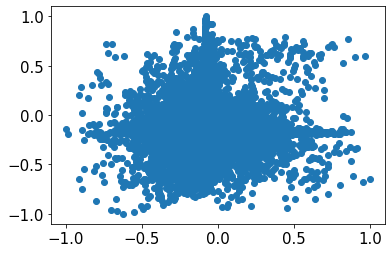

In [13]:
elements = np.random.choice(sound_np.shape[0], 3, replace=False)
elements = [0,2,1,5]
print(elements)
S = sound_np[elements,:]
S.min(), S.max()
# S = sound_np
NumberofMixtures = 4
NumberofSources = S.shape[0]
# INPUT_STD = 0.5
# A, X = WSM_Mixing_Scenario(S, NumberofMixtures, INPUT_STD)
A = ortho_group.rvs(NumberofMixtures)
X = A @ S

SNR=30

# X, NoisePart = addWGN(X, SNR, return_noise = True)

# SNRinp = 10 * np.log10(np.sum(np.mean((X - NoisePart)**2, axis = 1)) / np.sum(np.mean(NoisePart**2, axis = 1)))
print("The following is the mixture matrix A")
display_matrix(A)
# print("Input SNR is : {}".format(SNRinp))

plt.scatter(S[0,:], S[2,:])
plt.show()

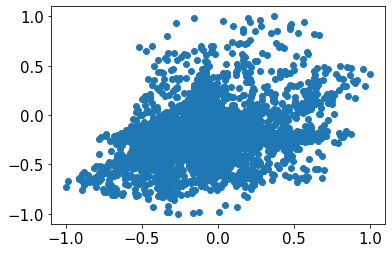

In [14]:
plt.scatter(S[0,:], S[1,:])
plt.show()

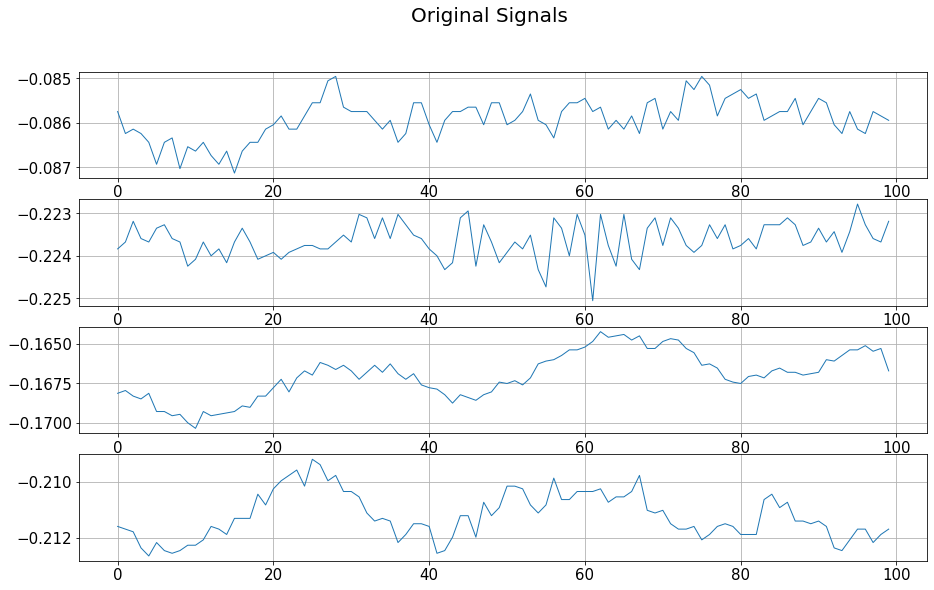

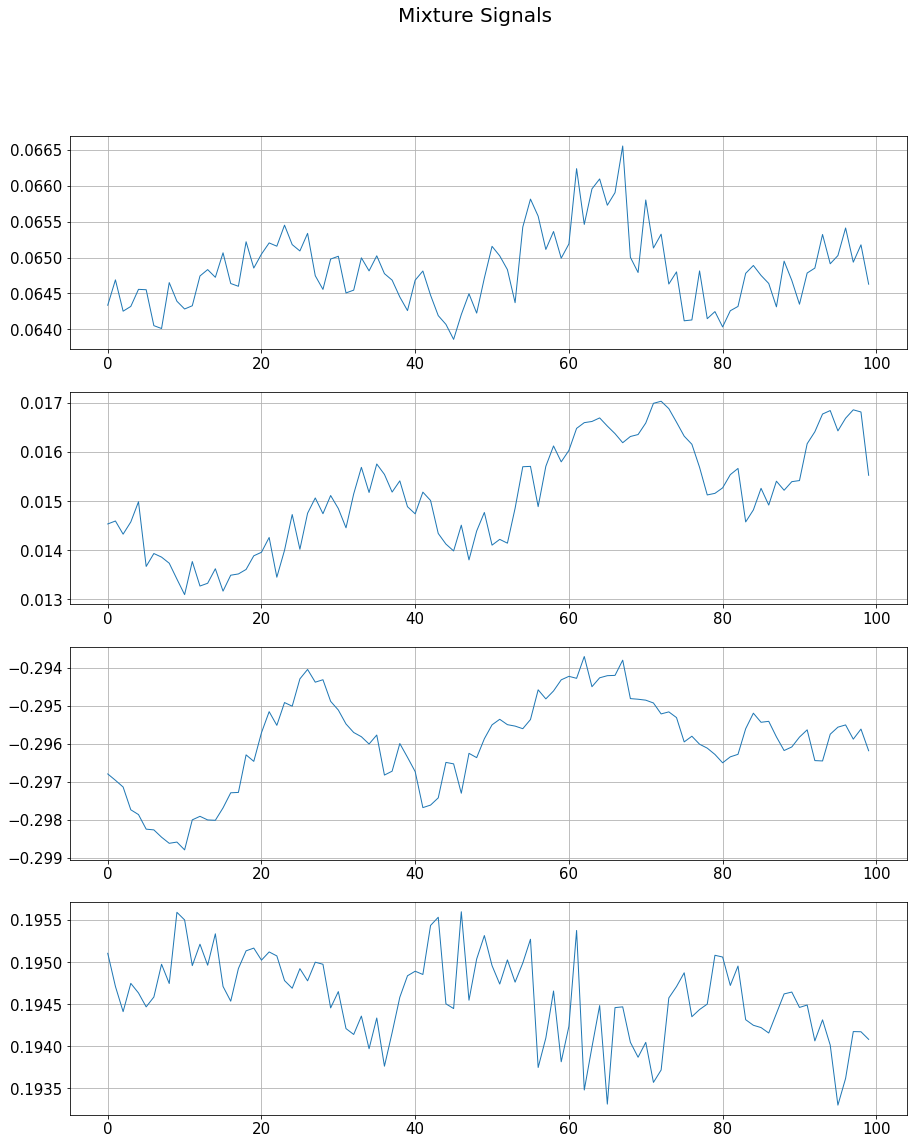

In [15]:
subplot_1D_signals(S.T[0:100], title = 'Original Signals', figsize = (15.2,9), colorcode = None)
subplot_1D_signals(X.T[0:100], title = 'Mixture Signals', figsize = (15,18), colorcode = None)

In [16]:
NumberofSources = S.shape[0]
NumberofMixtures = X.shape[0]
MUS = 0.9
OUTPUT_COMP_TOL = 1e-5
MAX_OUT_ITERATIONS= 3000
LayerActivationArguments = [0,1]
LayerGains = [4,1]
LayerMinimumGains = [1e-2,0.2]
LayerMaximumGains = [1e6,2.2]
WScalings = [0.0033,0.0033]
GamScalings = [0.02,0.02]
zeta = 1e-5
beta = 0.5
muD = [0.01, 1e-3]

s_dim = S.shape[0]
x_dim = X.shape[0]
h_dim = 2
samples = S.shape[1]

# THE OnlineWSMBSS is imported from WSMBSS.py Python script which I wrote
model = OnlineWSMBSS(s_dim = s_dim, x_dim = x_dim, h_dim = h_dim, 
                     gamma_start = MUS, beta = beta, zeta = zeta, 
                     muD = muD,WScalings = WScalings,
                     DScalings = LayerGains, LayerMinimumGains = LayerMinimumGains,
                     LayerMaximumGains = LayerMaximumGains,neural_OUTPUT_COMP_TOL = OUTPUT_COMP_TOL,
                     set_ground_truth = True, S = S, A = A)

In [17]:
debug_iteration_point = 1000
model.fit_batch_antisparse(X, n_epochs = 1, neural_lr_start = 0.14, whiten = False, debug_iteration_point = debug_iteration_point)

100%|██████████| 45477/45477 [03:37<00:00, 208.92it/s]


In [ ]:
# MUS = 0.25
# OUTPUT_COMP_TOL = 1e-5
# MAX_OUT_ITERATIONS= 3000
# LayerGains = [8,1]
# LayerMinimumGains = [1e-6,1]
# LayerMaximumGains = [1e6,1.001]
# WScalings = [0.0033,0.0033]
# GamScalings = [0.02,0.02]
# zeta = 1*1e-4
# beta = 0.5
# muD = [20, 1e-2]

# s_dim = S.shape[0]
# x_dim = X.shape[0]
# h_dim = s_dim
# samples = S.shape[1]

In [ ]:
# debug_iteration_point = 10000
# modelWSM = OnlineWSMBSS(s_dim = s_dim, x_dim = x_dim, h_dim = h_dim, 
#                         gamma_start = MUS, beta = beta, zeta = zeta, 
#                         muD = muD,WScalings = WScalings, GamScalings = GamScalings,
#                         DScalings = LayerGains, LayerMinimumGains = LayerMinimumGains,
#                         LayerMaximumGains = LayerMaximumGains,neural_OUTPUT_COMP_TOL = OUTPUT_COMP_TOL,
#                         set_ground_truth = True, S = S, A = A)

# modelWSM.fit_batch_sparse(X, n_epochs = 1, 
#                           neural_lr_start = 0.3,
#                           debug_iteration_point = debug_iteration_point,
#                           plot_in_jupyter = True,
#                          )

In [ ]:
# MUS = 0.35
# OUTPUT_COMP_TOL = 1e-5
# MAX_OUT_ITERATIONS= 3000
# LayerGains = [1,1]
# LayerMinimumGains = [1,1]
# LayerMaximumGains = [1e6,1.001]
# WScalings = [0.0033,0.0033]
# GamScalings = [0.01,0.01]
# zeta = 1e-4
# beta = 0.5
# muD = [25, 1e-2]

# s_dim = S.shape[0]
# x_dim = X.shape[0]
# h_dim = s_dim
# samples = S.shape[1]
# W_HX = np.eye(h_dim, x_dim)
# W_YH = np.eye(s_dim, h_dim)

# NumberofSources = S.shape[0]
# NumberofMixtures = X.shape[0]
# MUS = 0.9
# OUTPUT_COMP_TOL = 1e-5
# MAX_OUT_ITERATIONS= 3000
# LayerActivationArguments = [0,1]
# LayerGains = [4,1]
# LayerMinimumGains = [1e-2,0.2]
# LayerMaximumGains = [1e6,2.2]
# WScalings = [0.0033,0.0033]
# GamScalings = [0.02,0.02]
# zeta = 1e-5
# beta = 0.5
# muD = [0.01, 1e-3]
# s_dim = S.shape[0]
# x_dim = X.shape[0]
# h_dim = 2
# samples = S.shape[1]

MUS = 0.6
gamma_start = MUS
gamma_stop = 1e-3
OUTPUT_COMP_TOL = 1e-6
MAX_OUT_ITERATIONS= 3000
LayerGains = [1,1]
LayerMinimumGains = [0.2,0.2]
LayerMaximumGains = [1e6,5]
WScalings = [0.005,0.005]
GamScalings = [2,1]
zeta = 5*1e-5
beta = 0.5
muD = [1.125, 0.2]

s_dim = S.shape[0]
x_dim = X.shape[0]
h_dim = s_dim
samples = S.shape[1]
W_HX = np.eye(h_dim, x_dim)
W_YH = np.eye(s_dim, h_dim)

In [ ]:
debug_iteration_point = 10000
modelWSM = OnlineWSMBSS(s_dim = s_dim, x_dim = x_dim, h_dim = h_dim, 
                        gamma_start = gamma_start, gamma_stop = gamma_stop, beta = beta, zeta = zeta, 
                        muD = muD,WScalings = WScalings, GamScalings = GamScalings,
                        W_HX = W_HX, W_YH = W_YH,
                        DScalings = LayerGains, LayerMinimumGains = LayerMinimumGains,
                        LayerMaximumGains = LayerMaximumGains,neural_OUTPUT_COMP_TOL = OUTPUT_COMP_TOL,
                        set_ground_truth = True, S = S, A = A)

modelWSM.fit_batch_antisparse(X, n_epochs = 5, 
                                neural_lr_start = 0.75,
                                neural_lr_stop = 0.05,
                                debug_iteration_point = debug_iteration_point,
                                plot_in_jupyter = True,
                                )

In [ ]:
Wf = modelWSM.compute_overall_mapping(return_mapping = True)
Y = Wf @ X
Y_ = signed_and_permutation_corrected_sources(S.T,Y.T)
coef_ = (Y_ * S.T).sum(axis = 0) / (Y_ * Y_).sum(axis = 0)
Y_ = coef_ * Y_

print("Component SNR Values : {}\n".format(snr(S.T, Y_)))

SINRwsm = 10*np.log10(CalculateSINR(Y_.T, S)[0])

print("Overall SINR : {}".format(SINRwsm))

In [ ]:
rate, a = wavfile.read('./sounds/MA02_04.wav')
rate, b = wavfile.read('./sounds/FA01_03.wav')
rate, c = wavfile.read('./sounds/FJ55_04.wav')
rate, d = wavfile.read('./sounds/MH43_08.wav')
rate, e = wavfile.read('./sounds/MH43_09.wav')

a = a.astype('float32')
b = b.astype('float32')
c = c.astype('float32')
d = d.astype('float32')
e = e.astype('float32')

a_max = np.max(a)
b_max = np.max(b)
c_max = np.max(c)
d_max = np.max(d)
e_max = np.max(e)

a /= a_max
b /= b_max
c /= c_max
d /= d_max
e /= e_max

shortest = min(len(a), len(b), len(c), len(d), len(e))
a = a[:shortest]
b = b[:shortest]
c = c[:shortest]
d = d[:shortest]
e = e[:shortest]

np.random.seed(101)
noise = np.random.uniform(-1, 1, len(a))
sources = np.stack((a, b, c, d, e, noise))

In [ ]:
display_matrix(np.corrcoef(sources))